# Like it or not: how to use likelihoods to infer parameters

Question: The number of named hurricanes varies from decade to decade. Is the observed difference real or random?

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['text.usetex'] = True
# NOAA dataset, can be downloaded from Kaggle
df = pd.read_csv('atlantic.csv')
# convert Date to date format
df['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')

In [22]:
df.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,1851-06-25,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,1851-06-25,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,1851-06-25,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,1851-06-25,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,1851-06-25,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [56]:
# count the number of named hurricanes/TCs during the 1990s
msk = (df['Date'] >= '1990-1-1') & (df['Date'] < '1999-12-31') & (df['Name'] != '            UNNAMED')
df1990 = df.loc[msk]
x1 = len(df1990['Name'].unique())
x1

77

In [70]:
# count the number of named hurricanes/TCs during the 2000s
msk = (df['Date'] >= '2000-1-1') & (df['Date'] < '2009-12-31') & (df['Name'] != '            UNNAMED')
df2000 = df.loc[msk]
x2 = len(df2000['Name'].unique())
x2

117

So we have 77 observed, named hurricances in the 1990s and 117 in the 2000s.

To proceed, we build a likelihood function. The likelihoood function is proprotional to the probability of observing the data given some assumptions about the probability distribution of the problem. Since we're counting events during fixed intervals, we choose the Poisson distribution

$P(X = x) = \lambda^x e^{-\lambda} / x!$

where $X$ is the random variable (the number of events), $x$ is the observed number of events, $P(X = x)$ is the probability to observe $x$ events and $\lambda$ is the expected number of events.

Assuming that the number of hurricane is an independent from one decade to the next (?), the likelihood function is

$L \propto P(X_1 = x_1) P(X_2 = x_2) \propto \lambda_1^{x_1} e^{-\lambda_1} \lambda_2^{x_2} e^{-\lambda_2}$

Now we're not interested in $\lambda_1, \lambda_2$ individually but instead in $\theta \equiv \lambda_2/\lambda_1$, i.e. the ratio of the expected number of hurricanes and whether this ratio increased or not. 

Hence, we rewrite the likelihood $L$ as
$L \propto \lambda_1^{x_1 + x_2} \theta^{x_2} e^{-\lambda_1 \lambda_1}$ 

We can eliminate $\lambda_1$ by setting
$\frac{\partial log(L)}{\partial \lambda_1} = \frac{x_1 + x_2}{\lambda_1} - (1 + \theta) = 0.$
That is, we choose $\lambda_1$ to maximise $L$ (or equivalently $log(L)$). This value is called the Maximum Likelihood Estimate (MLE in short) and it is customary to denote it with a $\hat{}$. Here, we get

$\hat{\lambda_1} = \frac{x_1 + x_2}{1 + \theta}.$

Plugging this expression into the likelihood gives (profile) likelihood

$L \propto \theta^{x_2} / (1 + \theta)^{x_1 + x_2}$

which is plotted below


Text(0.5, 0, 'theta')

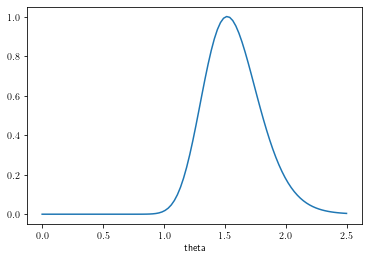

In [79]:
# plot the profile likelihood
def Lfunc(theta):
    return theta**x2/(1 + theta)**(x1 + x2)

thetas = np.linspace(0, 2.5, 100)
Ls = Lfunc(thetas)
maxLs = np.amax(Ls)
fig, ax = plt.subplots()
ax.plot(thetas, Ls/maxLs)
ax.set_xlabel('theta')

We find that the most likely ratio $\theta$ is around 1.5 ($x_2/x_1 = 1.52$), not too surprising.

More importantly, we can estimate the probability that $\theta = 1$ from $L(1)/L(\hat{\theta}) = 0.016$.

In [80]:
Lfunc(1)/Lfunc(1.52)

0.015710353717836304

We can estimate the 95% confidence interval

In [81]:
from scipy.optimize import fsolve
def f(t):
    return Lfunc(t)/Lfunc(1.52) - 0.05
lo = fsolve(f, [1.])[0]
hi = fsolve(f, [1.7])[0]
print(f'95% confidence interval is [{lo:.3f}, {hi:.3f}]')

95% confidence interval is [1.065, 2.188]


Text(0.5, 0, 'theta')

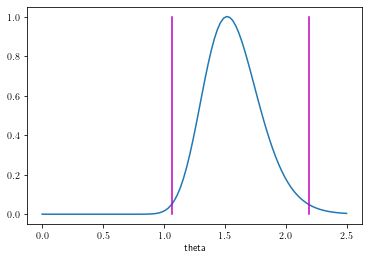

In [82]:
fig, ax = plt.subplots()
ax.plot(thetas, Ls/maxLs)
ax.plot([lo, lo], [0, 1.], 'm')
ax.plot([hi, hi], [0, 1.], 'm')
ax.set_xlabel('theta')